## Post_Analysis3
- Mapping

In [1]:
import os
import numpy as np
import HydroErr as he
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [33]:
# Load Dam Inflow data from SUTD
dfFlowDams = pd.read_hdf('./data/dfFlowDams.hdf')
ind_dams = np.load('./data/ind_dams.npz')['ind_dams']
# Load Degree of Regulation (DOR)
dor = pd.read_hdf('./data/new_dor.hdf')      # The order is sorted during the process
dam_dor = dor.loc[dor.DOR2 <= 0, 'GRAND_ID']
# Select only headwater dams (735)
idx_dor = np.isin(ind_dams[0,:], dam_dor)
damList = ind_dams[0,idx_dor]
ind_dams = ind_dams[1,idx_dor]
ndam = len(damList)

# Load variables
# Number of predicted months per each climate predictor 
NumMonCorr = pd.read_hdf('./data/NumMonCorr.hdf','df')
NumMonCorr = NumMonCorr.loc[damList].reset_index()

# Number of predicted months and KGE at each dam
subset = pd.read_hdf('./data/subset.hdf', 'df')
subset['NMON_MP14'] =  subset['NMON_MP4'] - subset['NMON_MP1']
subset['NMON_MP17'] = subset['NMON_MP7'] - subset['NMON_MP1']
subset['KGE_MP14'] = subset['KGE_MP4'] - subset['KGE_MP1']
subset['KGE_MP17'] = subset['KGE_MP7'] - subset['KGE_MP1']
subset = subset.loc[damList].reset_index()

# Load hydropower production results
prod = pd.read_hdf('./data/hydropower_production.hdf').loc[damList].reset_index()[['GRAND_ID','PF','DF']]

# Merge DataFrames
subset = pd.merge(subset, prod, on='GRAND_ID', how='inner')
subset.head()

# Load analysis data
data = pd.read_hdf('./data/data_analysis.hdf')

# Load GSS and MSESS
table_gss = pd.read_hdf('./data/prediction/dfGSS.hdf')
table_msess = pd.read_hdf('./data/prediction/dfMSESS.hdf')

### Initialize mapping parameters

In [21]:
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, Transformer, transform
from tools import cbarpam, GDFPlotOrder
# Load 1593 GranD dam shapefile
gdfDam = gpd.read_file('./data/granddams_eval.shp')
gdfDam = gdfDam.drop(gdfDam.columns[1:-1], axis=1)
gdfDam = gdfDam.set_index('GRAND_ID').loc[damList].reset_index(drop=False)
# Load world base map (exclude Antarctica)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]
# Reprojection to Robinson projection (ESRI:54030)
lims = [-135, 167, -55, 80]
if True:
    world = world.to_crs('esri:54030')
    gdfDam = gdfDam.to_crs('esri:54030')
    Transformer = Transformer.from_crs('epsg:4326', 'esri:54030')
    xmin, _ = Transformer.transform(0, lims[0])
    xmax, _ = Transformer.transform(0, lims[1])
    _, ymin = Transformer.transform(lims[2], 0)
    _, ymax = Transformer.transform(lims[3], 0)    
    lims = [xmin, xmax, ymin, ymax]

### (a) The number of months predicted and weighted KGE for 3 lead-months (MP1-3 models)

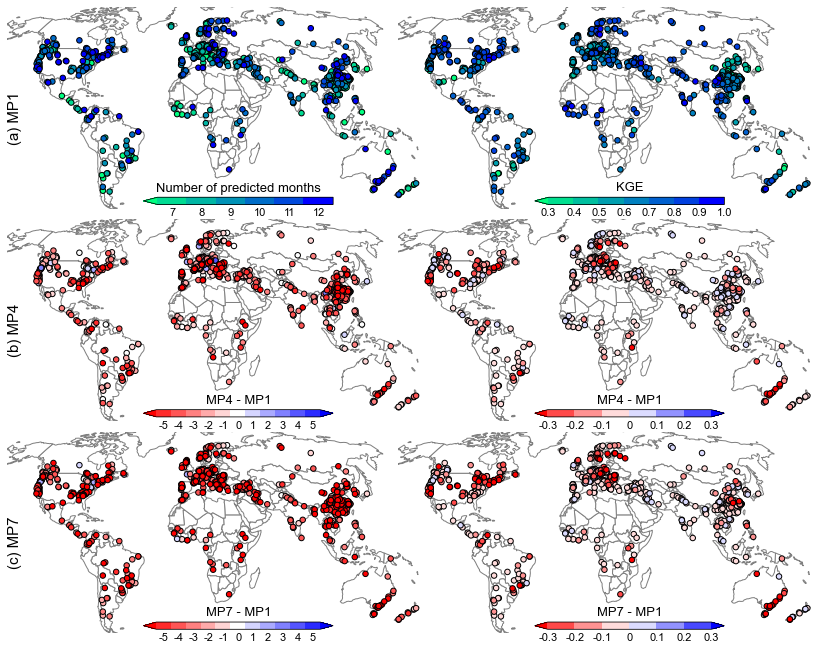

In [20]:
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(subset, on='GRAND_ID')

# Colormaps
# (1) Number of predicted months of MP1
bounds1 = list(np.arange(6.5,13.5,1))
boundaries1 = [0] + bounds1
cmap1, norm1, vmin1, vmax1, ticks1, boundaries1 = cbarpam(bounds1, 'winter_r', labloc='in',
                                                          boundaries=boundaries1, extension='min')
# (2) Difference of number of predicted months from MP1
bounds2 = list(np.arange(-5.5,6.5,1))
boundaries2 = [-10]+bounds2+[10]
cmap2, norm2, vmin2, vmax2, ticks2, boundaries2 = cbarpam(bounds2, 'bwr_r', labloc='in',
                                                          boundaries=boundaries2, extension='both')
# (3) KGE of MP1
bounds3 = list(np.arange(0.3,1.1,0.1))
boundaries3 = [-1]+bounds3
cmap3, norm3, vmin3, vmax3, ticks3, boundaries3 = cbarpam(bounds3, 'winter_r', labloc='on',
                                                          boundaries=boundaries3, extension='min')
# (4) Difference of KGE from MP1
bounds4 = list(np.arange(-0.3,0.4,0.1))
boundaries4 = [-1]+bounds4+[1]
cmap4, norm4, vmin4, vmax4, ticks4, boundaries4 = cbarpam(bounds4, 'bwr_r', labloc='on',
                                                          boundaries=boundaries4, extension='both')

# Plotting
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,9), facecolor='w')
figLabel = ['(a) MP1','(b) MP4','(c) MP7']
colList = ['NMON_MP1','NMON_MP14','NMON_MP17','KGE_MP1','KGE_MP14','KGE_MP17']
for (i, el) in enumerate(colList):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    if i == 0:
        GDFPlotOrder(damMap, boundaries1, ax, el, 
                     cmap1, norm1, vmin1, vmax1, order='seq')
    elif i == 1 or i == 2:        
        GDFPlotOrder(damMap, boundaries2, ax, el, 
                     cmap2, norm2, vmin=vmin2, vmax=vmax2, order='div')
    elif i == 3:
        GDFPlotOrder(damMap, boundaries3, ax, el, 
                     cmap3, norm3, vmin=vmin3, vmax=vmax3, order='seq')  
    else:
        GDFPlotOrder(damMap, boundaries4, ax, el, 
                     cmap4, norm4, vmin=vmin4, vmax=vmax4, order='div')
    if i < 3:
        ax.annotate(figLabel[i], xy=(0.02, 0.45), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15,rotation=90)
plt.tight_layout(w_pad=-5)
# Colorbars
for i in range(6):
    ax = axes.flatten('F')[i]
    cax = inset_axes(ax, width="46%", height="3%", loc='lower left',
                     bbox_to_anchor=(0.33, 0.02, 1, 1.2),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    if i == 0:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1,
                                         boundaries=boundaries1,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks1,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%d'%lb for lb in ticks1]
        clabel = 'Number of predicted months'
    elif i == 1 or i==2:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2,
                                         boundaries=boundaries2,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks2,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%d'%lb for lb in ticks2]
        if i == 1:
            clabel = 'MP4 - MP1'
        else:
            clabel = 'MP7 - MP1'
    elif i == 3:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3,
                                         boundaries=boundaries3,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks3,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%.1f'%lb for lb in ticks3]
        tlabel[0] = '0.3'; #tlabel = np.array(tlabel); tlabel[1::2] = ''
        clabel = 'KGE'
    else:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap4, norm=norm4,
                                         boundaries=boundaries4,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks4,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%.1f'%lb for lb in ticks4]
        tlabel[3] = '0'
        if i == 4:
            clabel = 'MP4 - MP1'
        else:
            clabel = 'MP7 - MP1'
    cbar.ax.set_xticklabels(tlabel, fontname='arial', fontsize=11)
    cbar.ax.tick_params(length=0)
    cbar.set_label(clabel, labelpad=-36, 
                   fontname='arial', fontsize=13, 
                   horizontalalignment='center')
    cbar.outline.set_edgecolor('black')
plt.show()
# Save a figure
if False:
    fn_save = './figures/dam_pmonth_kge.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### (b) Number of months correlated with predictor (MP1)

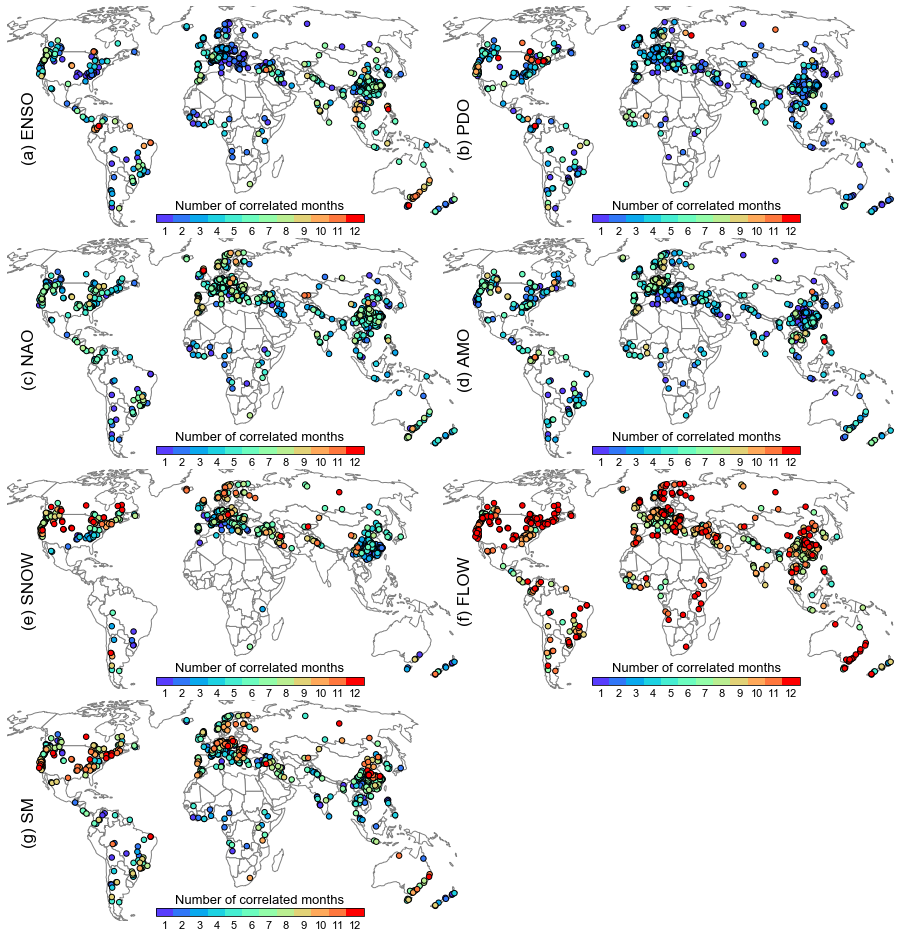

./figures/nmon_correlated.pdf is saved.


In [5]:
# (a) The number of months predicted and weighted KGE for 3 lead-months (MP1-3 models)
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(NumMonCorr, on='GRAND_ID')

# Colormaps
# (1) Number of correlated months of MP1
bounds = list(np.arange(0.5,13.5,1))
boundaries = bounds
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'rainbow', labloc='in',
                                                    boundaries=boundaries, extension='min')

# Plotting
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(15,13), facecolor='w')
figLabel = ['(a) ENSO','(b) PDO','(c) NAO','(d) AMO','(e) SNOW','(f) FLOW', '(g) SM']
colList = ['ENSO','PDO','NAO','AMO','SNOW','FLOW','SM']
for (i, el) in enumerate(colList):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    GDFPlotOrder(damMap, boundaries, ax, el, cmap, norm, vmin, vmax, order='seq')
    ax.annotate(figLabel[i], xy=(0.05, 0.45), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=17,rotation=90,backgroundcolor='w')

ax = axes.flatten('F')[7]
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
    
plt.tight_layout(w_pad=-12)
# Colorbars
for i in range(7):
    ax = axes.flatten('C')[i]
    cax = inset_axes(ax, width="46%", height="3%", loc='lower left',
                     bbox_to_anchor=(0.33, 0.02, 1, 1.2),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                     boundaries=boundaries,
                                     ticks = ticks,
                                     spacing='uniform',
                                     orientation='horizontal')
    tlabel = ['%d'%lb for lb in ticks]
    clabel = 'Number of correlated months'
    cbar.ax.set_xticklabels(tlabel, fontname='arial', fontsize=11)
    cbar.ax.tick_params(length=0)
    cbar.set_label(clabel, labelpad=-36, 
                   fontname='arial', fontsize=13, 
                   horizontalalignment='center')
    cbar.outline.set_edgecolor('black')
plt.show()
# Save a figure
if True:
    fn_save = './figures/nmon_correlated.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### (c) Improvements in hydropower production

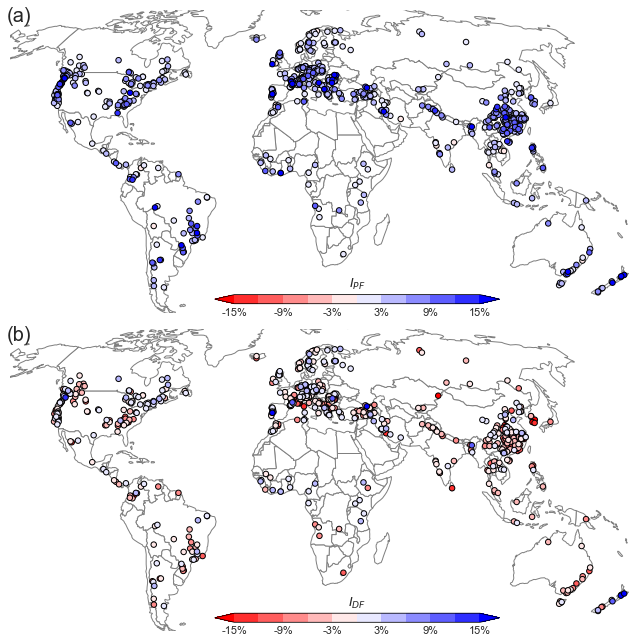

./figures/dam_improvements.pdf is saved.


In [32]:
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(subset, on='GRAND_ID')

# Colormap
bounds = list(np.arange(-15,16,3))
boundaries = [-100]+bounds+[100]
cmap, norm, vmin, vmax, ticks, boundaries = cbarpam(bounds, 'bwr_r', labloc='on', 
                                                    boundaries=boundaries, extension='both')
# Plotting
fignumb = ['(a)', '(b)']
figlabel = ['$I_{PF}$', '$I_{DF}$']
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(9,9), facecolor='w')
for (i, el) in enumerate(['PF', 'DF']):
    ax = axes[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    mask = np.abs(damMap[el]) < 3
#     damMap[mask].plot(ax=ax, markersize=30, edgecolor='#525252', facecolor=(0,0,0,0))
#     GDFPlotOrder(damMap[~mask], boundaries, ax, el, cmap, norm, vmin, vmax, order='seq', markersize=30)
    GDFPlotOrder(damMap, boundaries, ax, el, cmap, norm, vmin, vmax, order='seq', markersize=30)
    ax.annotate(fignumb[i], xy=(0.015, 0.98), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
plt.tight_layout()
# Colorbar
for (i, el) in enumerate(['PF', 'DF']):
    ax = axes[i]
    cax = inset_axes(ax,
                     width="46%",
                     height="3%",
                     loc='lower left',
                     bbox_to_anchor=(0.33, 0.03, 1, 1),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                     boundaries=boundaries,
                                     extend='both',
                                     extendfrac=0.08,
                                     ticks = bounds[0::2],
                                     spacing='uniform',
                                     orientation='horizontal')
    cbar.ax.set_xticklabels([str(lab)+'%' for lab in bounds[0::2]], 
                            fontname='arial', fontsize=11)
    cbar.ax.tick_params(length=0)
    cbar.set_label(figlabel[i], labelpad=-41, 
                   fontname='arial', fontsize=13, 
                   horizontalalignment='center')
    cbar.outline.set_edgecolor('black')
plt.show()
# Save a figure
if True:
    fn_save = './figures/dam_improvements.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### (d) Dam classification map

/Users/dlee/anaconda3/envs/dlee_sovi/lib/python3.6/site-packages/geopandas/plotting.py:404: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


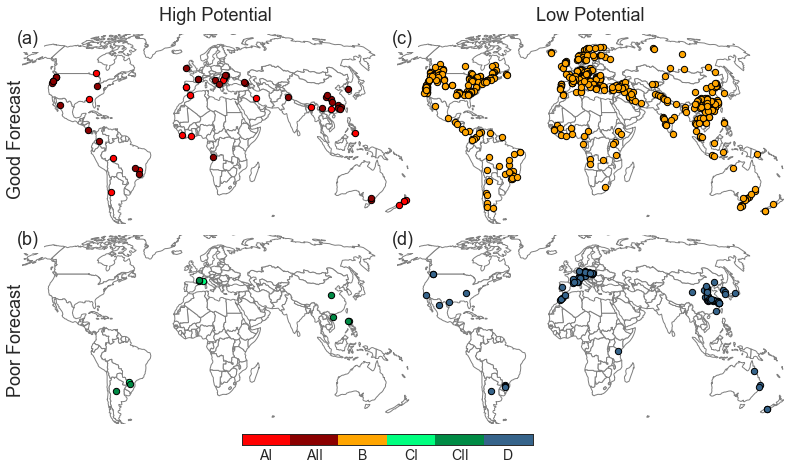

./figures/dam_class.pdf is saved.


In [7]:
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})

# Dam classification 6 plots
damMap = gdfDam.merge(data, on='GRAND_ID')
GroupColor = ['#FF0000','#8B0000','#FFA500','#00FF7F','#008B45','#36648B']
bounds = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]
cmap, norm, _, _, ticks, boundaries = cbarpam(bounds, GroupColor, labloc='in',
                                              boundaries=bounds, extension=None)
# Plotting
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(11.5,6), facecolor='w')
fignumb = ['(a)', '(b)', '(c)', '(d)']
for (i, el) in enumerate(fignumb):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    if i == 0:
        damMap[damMap['class'] == 1].plot(ax=ax, column='class',markersize=40, edgecolor='black', 
                                        color=GroupColor[0])
        damMap[damMap['class'] == 2].plot(ax=ax, column='class',markersize=40, edgecolor='black', 
                                        color=GroupColor[1])
        ax.annotate('Good Forecast', xy=(-0.015, 0.45), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w", rotation=90)
        ax.annotate('High Potential', xy=(0.5, 1.1), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w")
    elif i == 1:
        damMap[damMap['class'] == 4].plot(ax=ax, column='class',markersize=40, edgecolor='black', 
                                        color=GroupColor[3])
        damMap[damMap['class'] == 5].plot(ax=ax, column='class',markersize=40, edgecolor='black', 
                                        color=GroupColor[4])
        ax.annotate('Poor Forecast', xy=(-0.015, 0.45), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w", rotation=90)
    elif i == 2:
        damMap[damMap['class'] == 3].plot(ax=ax, column='class',markersize=40, edgecolor='black', 
                                        color=GroupColor[2])
        ax.annotate('Low Potential', xy=(0.5, 1.1), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w")
    elif i == 3:
        damMap[damMap['class'] == 6].plot(ax=ax, column='class',markersize=40, edgecolor='black', 
                                        color=GroupColor[5])

    ax.annotate(fignumb[i], xy=(0.015, 0.98), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w")
plt.tight_layout(w_pad=-5)


# Colorbar
cax = inset_axes(ax, width="75%", height="5%", loc='lower left',
                 bbox_to_anchor=(-0.40, -0.11, 1, 1.2),
                 bbox_transform=ax.transAxes,
                 borderpad=0)

cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                 boundaries = boundaries,
                                 ticks=ticks,
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['AI','AII','B','CI','CII','D'], 
                        fontname='arial', fontsize=14, backgroundcolor='w')
cbar.ax.tick_params(length=0, width=1)
cbar.ax.set_frame_on(True)


plt.show()
# Save a figure
if True:
    fn_save = './figures/dam_class.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### (b) GSS and MSESS maps

In [53]:
# Skill scores
gss = table_gss[['MP1', 'MP4', 'MP7']].reset_index()
gss.columns = ['GRAND_ID', 'GSS_MP1', 'GSS_MP4', 'GSS_MP7']
msess = table_msess[['MP1', 'MP4', 'MP7']].reset_index()
msess.columns = ['GRAND_ID', 'MSESS_MP1', 'MSESS_MP4', 'MSESS_MP7']
skill = gss.merge(msess, on='GRAND_ID')
skill['GSS_MP14'] =  skill['GSS_MP4'] - skill['GSS_MP1']
skill['GSS_MP17'] = skill['GSS_MP7'] - skill['GSS_MP1']
skill['MSESS_MP14'] = skill['MSESS_MP4'] - skill['MSESS_MP1']
skill['MSESS_MP17'] = skill['MSESS_MP7'] - skill['MSESS_MP1']

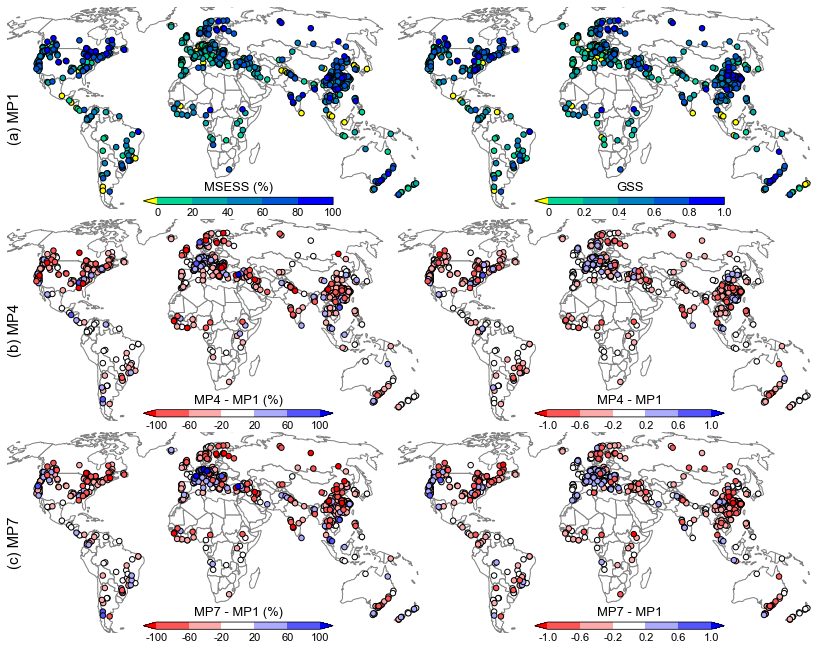

./figures/dam_msess_gss.pdf is saved.


In [98]:
# Merge Geodataframe of dam and Series of data we want to plot
damMap = gdfDam.merge(skill, on='GRAND_ID')

# Colormaps
# (1) MSESS of MP1
bounds1 = list(np.arange(0,110,20))
boundaries1 = [-100000] + bounds1
cmap1, norm1, vmin1, vmax1, ticks1, boundaries1 = cbarpam(bounds1, 'winter_r', labloc='on',
                                                          boundaries=boundaries1, extension='min')
cmap1.set_under('yellow')
# (2) Difference of MSESS from MP1
bounds2 = list(np.arange(-100,101,40))
boundaries2 = [-10000]+bounds2+[10000]
cmap2, norm2, vmin2, vmax2, ticks2, boundaries2 = cbarpam(bounds2, 'bwr_r', labloc='on',
                                                          boundaries=boundaries2, extension='both')
# (3) GSS of MP1
bounds3 = list(np.arange(0,1.1,0.2))
boundaries3 = [-10000]+bounds3
cmap3, norm3, vmin3, vmax3, ticks3, boundaries3 = cbarpam(bounds3, 'winter_r', labloc='on',
                                                          boundaries=boundaries3, extension='min')
cmap3.set_under('yellow')
# (4) Difference of GSS from MP1
bounds4 = list(np.arange(-1,1.2,0.4))
boundaries4 = [-100]+bounds4+[100]
cmap4, norm4, vmin4, vmax4, ticks4, boundaries4 = cbarpam(bounds4, 'bwr_r', labloc='on',
                                                          boundaries=boundaries4, extension='both')

# Plotting
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(12,9), facecolor='w')
figLabel = ['(a) MP1','(b) MP4','(c) MP7']
colList = ['MSESS_MP1','MSESS_MP14','MSESS_MP17', 'GSS_MP1','GSS_MP14','GSS_MP17']
for (i, el) in enumerate(colList):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    world.plot(ax=ax, color='white', edgecolor='gray')
    if i == 0:
        GDFPlotOrder(damMap, boundaries1, ax, el, 
                     cmap1, norm1, vmin1, vmax1, order='seq')
    elif i == 1 or i == 2:        
        GDFPlotOrder(damMap, boundaries2, ax, el, 
                     cmap2, norm2, vmin=vmin2, vmax=vmax2, order='div')
    elif i == 3:
        GDFPlotOrder(damMap, boundaries3, ax, el, 
                     cmap3, norm3, vmin=vmin3, vmax=vmax3, order='seq')  
    else:
        GDFPlotOrder(damMap, boundaries4, ax, el, 
                     cmap4, norm4, vmin=vmin4, vmax=vmax4, order='div')
    if i < 3:
        ax.annotate(figLabel[i], xy=(0.02, 0.45), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=15,rotation=90)
plt.tight_layout(w_pad=-5)
# Colorbars
for i in range(6):
    ax = axes.flatten('F')[i]
    cax = inset_axes(ax, width="46%", height="3%", loc='lower left',
                     bbox_to_anchor=(0.33, 0.02, 1, 1.2),
                     bbox_transform=ax.transAxes,
                     borderpad=0)
    if i == 0:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1,
                                         boundaries=boundaries1,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks1,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%d'%lb for lb in ticks1]
        clabel = 'MSESS (%)'
    elif i == 1 or i==2:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2,
                                         boundaries=boundaries2,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks2,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%d'%lb for lb in ticks2]
        if i == 1:
            clabel = 'MP4 - MP1 (%)'
        else:
            clabel = 'MP7 - MP1 (%)'
    elif i == 3:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3,
                                         boundaries=boundaries3,
                                         extend='min',
                                         extendfrac=0.08,
                                         ticks = ticks3,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%.1f'%lb for lb in ticks3]
        tlabel[0] = '0'; #tlabel = np.array(tlabel); tlabel[1::2] = ''
        clabel = 'GSS'
    else:
        cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap4, norm=norm4,
                                         boundaries=boundaries4,
                                         extend='both',
                                         extendfrac=0.08,
                                         ticks = ticks4,
                                         spacing='uniform',
                                         orientation='horizontal')
        tlabel = ['%.1f'%lb for lb in ticks4]
#         tlabel[3] = '0'
        if i == 4:
            clabel = 'MP4 - MP1'
        else:
            clabel = 'MP7 - MP1'
    cbar.ax.set_xticklabels(tlabel, fontname='arial', fontsize=11)
    cbar.ax.tick_params(length=0)
    cbar.set_label(clabel, labelpad=-36, 
                   fontname='arial', fontsize=13, 
                   horizontalalignment='center')
    cbar.outline.set_edgecolor('black')
plt.show()
# Save a figure
if True:
    fn_save = './figures/dam_msess_gss.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

In [89]:
sum((damMap['GSS_MP1'] < 0) | (damMap['MSESS_MP1'] < 0))/ndam

0.2761904761904762

In [94]:
sum((damMap['GSS_MP4'] < 0) | (damMap['MSESS_MP4'] < 0))/ndam

0.4326530612244898

In [95]:
sum((damMap['GSS_MP7'] < 0) | (damMap['MSESS_MP7'] < 0))/ndam

0.37551020408163266